In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore
from matplotlib.colors import LogNorm
import os
import pycwt as cwt
import pickle
import datetime as datetime
import operator


In [2]:
FS = 4 # E4 sampling rate
FREQ_ARRAY = np.append(np.arange(23, 26, 1), np.arange(6*24, 9*24, 24)) # for morlet
PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/FS)+'S' # find missing samples (datetime)

MODALITY = 'eda'

# wavelet and filter variables                    
mother = cwt.Morlet(6)
order = 2 # butter bandpass filter

PANDAS_RESAMPLE_RATE

'0.25S'

In [3]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

HDRS_variant = 'hamd_17_score'

LABEL_FOLDER_PATH = 'labels/'
SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/cwt_' + MODALITY + '_all_freq/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/' + MODALITY + '/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

In [4]:
# Filter functions
# To use: butter_bandpass_filter(signal, lowcut, highcut, fs, order=1)
# def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         sos = butter(order, [low, high], analog=False, btype='band', output='sos')
#         return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         sos = butter_bandpass(lowcut, highcut, fs, order=order)
        sos = butter(order, [lowcut, highcut], analog=False, btype='band', output='sos')
        y = sosfiltfilt(sos, data)
        return y

In [5]:
def plot_signal(df,
                column,
                subject, 
                tick_freq = 'W', 
                fs = FS,
                y_label = MODALITY):
    
    tick_freq_dict = {'D':FS*60*60*24, 'W':FS*60*60*24*7}
    t = df.index[::tick_freq_dict[tick_freq]]
    
    fig, ax = plt.subplots(figsize=(15, 2))     
    x = df[column]
    ax.plot(range(len(df.index)), x)
    # plt.legend(loc=1)
    
    ax.set_xticks(range(len(df.index))[::tick_freq_dict[tick_freq]], [xt.to_pydatetime().strftime('%Y-%m-%d') for xt in t], rotation='vertical')
    ax.set_title(subject)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    plt.grid()

In [6]:
def plot_morlet(df, 
                column, 
                tick_freq, 
                subject): 
    
    resampled_df = df[column].resample(tick_freq).mean()
    cwtm = resampled_df.to_numpy().T # (len(freq_list), len(t))

    tick_freq_dict = {'T':60*24*7, 'H':24*7, 'D':7, 'W':1}
    xtick_freq = tick_freq_dict[tick_freq]

    fig, ax = plt.subplots(figsize=(15, 2)) 
    t = resampled_df.index.to_pydatetime()

    sns.heatmap(cwtm,
                norm=LogNorm(vmin=cwtm.min(), vmax=cwtm.max()),
                cmap="Blues",
                ax=ax)

    # plt.legend(loc=1)


    ax.set_xticks(np.arange(len(t))[::xtick_freq], [xt.strftime('%Y-%m-%d') for xt in t[::xtick_freq]], rotation='vertical')
    ax.set_yticks(np.arange(len(column))+0.5, column, rotation='horizontal')
    ax.set_title(subject, y = 1.1)

In [7]:
circadian_f = '24.0'
weekly_f = '168.0'

worn_percent_list = []
day_length_list = []


for file in os.listdir(SAVE_CWT_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("cwt.h5"):
        
        subject = filename.split('_')[0]
        eda_filepath = SAVE_CWT_FOLDER+filename
        df_cwt = pd.read_hdf(eda_filepath, 'df')        

        raw_filepath = DATA_FOLDER_PATH + subject + '_' + MODALITY + '_worn_left.h5'        
        raw_signal_df = pd.read_hdf(raw_filepath)
        worn_length = len(raw_signal_df)
        
        raw_signal_df = raw_signal_df.resample(PANDAS_RESAMPLE_RATE).mean() # NaN for missing data
        resampled_length = len(raw_signal_df)
        
        worn_percent = worn_length / resampled_length
        worn_percent_list.append(worn_percent)
        
        raw_signal_df = raw_signal_df.resample('D').mean() 
        day_length = len(raw_signal_df)
        day_length_list.append(day_length)
    
        print(subject, "{:.3f}".format(worn_percent), day_length)
    
#         if worn_percent > 0.9: 
#             plot_signal(raw_signal_df, 
#                         column = MODALITY, 
#                         subject = subject)
        
#             cwt_filepath = SAVE_CWT_FOLDER + subject + '_cwt.h5'
#             df_cwt = pd.read_hdf(cwt_filepath)

#             plot_morlet(df_cwt, 
#                         column = [circadian_f], 
#                         tick_freq = 'H', 
#                         subject = subject)

#             raw_signal_df.fillna(raw_signal_df[MODALITY].median(), inplace=True)

#             circadian_freq = float(circadian_f)
#             raw_signal_df['bandpassed_' + circadian_f] = butter_bandpass_filter(raw_signal_df[MODALITY], 
#                                                                                lowcut = 1/((circadian_freq + (1/3)*circadian_freq) * 60 * 60), 
#                                                                                highcut = 1/((circadian_freq - (1/3)*circadian_freq) * 60 * 60), 
#                                                                                fs = FS, 
#                                                                                order=order)

#             plot_signal(raw_signal_df, 
#                         y_label = MODALITY, 
#                         column = 'bandpassed_' + circadian_f, 
#                         subject = subject)

#             weekly_freq = float(weekly_f)
#             raw_signal_df['bandpassed_' + weekly_f] = butter_bandpass_filter(raw_signal_df[MODALITY], 
#                                                                                lowcut = 1/((weekly_freq + (1/3)*weekly_freq) * 60 * 60), 
#                                                                                highcut = 1/((weekly_freq - (1/3)*weekly_freq) * 60 * 60), 
#                                                                                fs = FS, 
#                                                                                order=order)

#             plot_signal(raw_signal_df, 
#                         y_label = MODALITY, 
#                         column = 'bandpassed_' + weekly_f, 
#                         subject = subject)



SP41 0.376 69
SP71 0.813 88
SP70 0.605 81
SP36 0.608 93
SP43 0.577 84
SP22 0.886 82
SP61 0.856 83
SP15 0.482 88
SP3 0.721 85
SP40 0.740 83
SP34 0.800 85
SP69 0.363 82
SP29 0.872 89
SP60 0.739 85
SP6 0.858 84
SP65 0.738 85
SP24 0.908 86
SP16 0.778 85
SP33 0.827 84
SP45 0.734 94
SP59 0.802 84
SP27 0.506 62
SP55 0.712 84
SP2 0.825 85
SP47 0.935 85
SP21 0.496 81
SP1 0.773 85
SP12 0.600 85
SP11 0.843 85
SP5 0.531 84
SP44 0.568 86
SP30 0.650 83
SP28 0.749 86
SP72 0.836 85
SP31 0.676 82


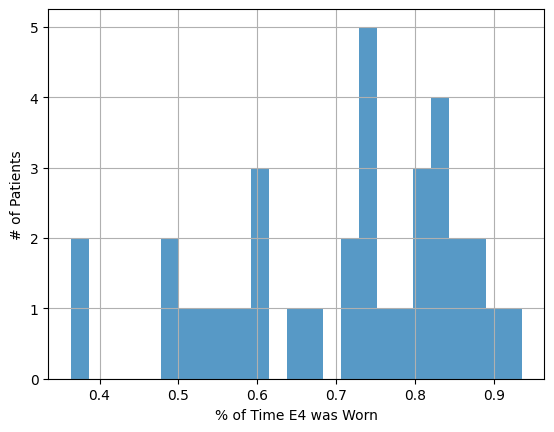

In [14]:
n, bins, patches = plt.hist(worn_percent_list, 25, alpha=0.75)


plt.xlabel('% of Time E4 was Worn')
plt.ylabel('# of Patients')
plt.grid(True)
plt.show()

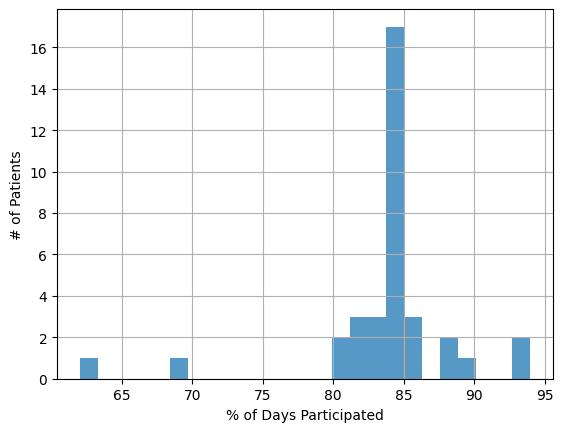

In [15]:
n, bins, patches = plt.hist(day_length_list, 25, alpha=0.75)


plt.xlabel('% of Days Participated')
plt.ylabel('# of Patients')
plt.grid(True)
plt.show()

In [8]:
print(np.mean(worn_percent_list), np.std(worn_percent_list))

print(np.mean(day_length_list), np.std(day_length_list))

0.7080590467278376 0.14833892196950252
83.91428571428571 5.352550412501254
